In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
import collections
from sklearn.metrics import silhouette_score

In [3]:
data=pd.read_csv('data/wb_dataset.txt', sep='\t',header=0)
data

,Time,Time Code,Country Name,Country Code,"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%) [SH.DYN.NCOM.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Current health expenditure per capita (current US$) [SH.XPD.CHEX.PC.CD],Out-of-pocket expenditure (% of current health expenditure) [SH.XPD.OOPC.CH.ZS],GDP (current US$) [NY.GDP.MKTP.CD],GDP per capita (current US$) [NY.GDP.PCAP.CD],Human capital index (HCI) (scale 0-1) [HD.HCI.OVRL]
0,2018,YR2018,Afghanistan,AFG,35.4,9.39572716,49.84260941,78.38278198,18053228578.8878,485.668418729808,0.393489241600037
1,2018,YR2018,Albania,ALB,11.8,5.26271439,274.91409302,44.58411789,15156432309.8977,5287.66369446913,0.628666281700134
2,2018,YR2018,Algeria,DZA,13.9,6.2184267,255.86943054,32.64655304,174910878623.049,4142.01855842917,0.531993925571442
3,2018,YR2018,American Samoa,ASM,..,..,..,..,639000000,11521.6097798453,..
4,2018,YR2018,Andorra,AND,..,6.71033096,2821.80126953,13.58695602,3218316013.22626,41791.9698372411,..
...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mortalité par cancer en fonction des dépenses en santé du pays, des dépenses directes de chaque citoyen en santé, du PIB et de l'indice de capital humain (World Bank Indice)

Attribute selection
===================

* Remove attributes containing many missing values.

* Remove attributes that seem redundant because of strong correlations.

* Used derived attributes to exhibit variables that could be more pertinent (relative value, ratio, difference, relative variation, indicator combining several attributes, ...).

* Choose a subset of the dimensions to focus on some aspects and/or to simplify the interpretations. For methods that use distances, reduce the number of dimensions between 4 and 6, and standardize the data if necessary.

Remark: It is possible to complete the dataset with other sources.

In [4]:
#Renaming attribute for easier use
# Time = removed
# Time Code = removed
# Country Name = country_name
# Country Code = country_code
# Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%) = mortality
# Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS] = health_cost_percent
# Current health expenditure per capita (current US$) [SH.XPD.CHEX.PC.CD] = health_cost_capita_percent
# Out-of-pocket expenditure (% of current health expenditure) [SH.XPD.OOPC.CH.ZS] = health_oop_cost
# GDP (current US$) [NY.GDP.MKTP.CD] = gdp
# GDP per capita (current US$) [NY.GDP.PCAP.CD] = gdp_capita
# Human capital index (HCI) (scale 0-1) [HD.HCI.OVRL] hci

In [5]:
#Drop the 2 first column (time and time code)
data.drop(["Time","Time Code"], axis=1, inplace=True)
# Remove the last 5 lines that are now empty
data.drop(data.tail(5).index,inplace=True)

In [6]:
data.columns = ['country_name','country_code','mortality','health_cost_percent','health_cost_capita_percent','health_oop_cost','gdp','gdp_capita','hci']
data

,country_name,country_code,mortality,health_cost_percent,health_cost_capita_percent,health_oop_cost,gdp,gdp_capita,hci
0,Afghanistan,AFG,35.4,9.39572716,49.84260941,78.38278198,18053228578.8878,485.668418729808,0.393489241600037
1,Albania,ALB,11.8,5.26271439,274.91409302,44.58411789,15156432309.8977,5287.66369446913,0.628666281700134
2,Algeria,DZA,13.9,6.2184267,255.86943054,32.64655304,174910878623.049,4142.01855842917,0.531993925571442
3,American Samoa,ASM,..,..,..,..,639000000,11521.6097798453,..
4,Andorra,AND,..,6.71033096,2821.80126953,13.58695602,3218316013.22626,41791.9698372411,..
...,...,...,...,...,...,...,...,...,...
261,Sub-Saharan Africa,SSF,21.5982120151935,5.15768660576918,83.2490352335023,33.3422917546122,1753414899266.08,1626.06247939811,..
262,Sub-Saharan Africa (excluding high income),SSA,21.5983081283383,5.15772866878292,83.1807940240755,33.3512591470402,1751867208506.64,1624.7729965878,..
263,Sub-Saharan Africa (IDA & IBRD countries),TSS,21.5982120151935,5.15768660576918,83.2490352335023,33.3422917546123,1753414899266.08,1626.06247939811,..
264,Upper middle income,UMC,16.8513728002943,5.82358644218712,532.032141629768,32.8682192051733,23638682947940,9468.93298334383,..


In [7]:
hcp=pd.to_numeric(data[data["health_cost_percent"]!=".."]["health_cost_percent"],downcast='float')
hccp=pd.to_numeric(data[data["health_cost_capita_percent"]!=".."]["health_cost_capita_percent"],downcast='float')
np.corrcoef(hcp,hccp)
#the correlation between health_cost_percent and health_cost_capita_percent does not seem to be significant enough to remove one of these two variables.

array([[1.        , 0.56630917],
       [0.56630917, 1.        ]])

In [8]:
gdp = pd.to_numeric(data[data["gdp"]!=".."]["gdp"],downcast='float')
gdpc = pd.to_numeric(data[data["gdp_capita"]!=".."]["gdp_capita"],downcast='float')
np.corrcoef(gdp,gdpc)
#As well, the correlation between gdp and gdp_capita does not seem to be significant enough to remove one of these two variables.

array([[1.        , 0.05888461],
       [0.05888461, 1.        ]])

Object selection
================

* Remove objects containing missing values (except if using methods that handle clearly the missing values).

* Identified the outliers (exceptional objects, noise, ...) in 1D, 2D, n-dimensions. Keep track of them and eventually remove them.


In [9]:
#We remove the region object because they are already agregate of data which we are not interested into
count_removed_region = len(data) - data.index[data['country_code'] == "ZWE"][0] - 1
if count_removed_region > 0 :
    data.drop(data.tail(count_removed_region).index,inplace=True)
    
print(count_removed_region)

49


In [10]:
#We remove objects for which we do not have data about cancers mortality
count_removed_nodata = len(data.loc[data['mortality'] == ".."])
if (count_removed_nodata > 0):
    data.drop(data.index[data['mortality'] == ".."],inplace=True)

print(count_removed_nodata)

34


In [11]:
#We choose to remove the objects for which at least one of the selected attributes is missing
missing_attributes = pd.DataFrame(data.apply(pd.Series.value_counts, axis=1)[".."])
missing_attributes_index = missing_attributes.index[missing_attributes[".."] > 0]
if (len(missing_attributes_index)>0):
    data.drop(missing_attributes_index,inplace=True)
print(len(missing_attributes_index))
data

27


,country_name,country_code,mortality,health_cost_percent,health_cost_capita_percent,health_oop_cost,gdp,gdp_capita,hci
0,Afghanistan,AFG,35.4,9.39572716,49.84260941,78.38278198,18053228578.8878,485.668418729808,0.393489241600037
1,Albania,ALB,11.8,5.26271439,274.91409302,44.58411789,15156432309.8977,5287.66369446913,0.628666281700134
2,Algeria,DZA,13.9,6.2184267,255.86943054,32.64655304,174910878623.049,4142.01855842917,0.531993925571442
5,Angola,AGO,22.1,2.54900527,87.61676788,36.79880905,101353230784.594,3289.64399476678,0.360190957784653
6,Antigua and Barbuda,ATG,17.7,5.23155928,875.17254639,29.45855904,1605944444.44444,16679.5916624545,0.578216969966888
...,...,...,...,...,...,...,...,...,...
207,Uruguay,URY,16.9,9.20269966,1590.04821777,16.9604454,64515038268.1373,18703.8602924478,0.602367758750916
209,Vanuatu,VUT,39.8,3.37372637,105.3915863,8.99114323,914727908.137793,3125.40499918952,0.444750398397446
211,Vietnam,VNM,21.4,5.91789675,151.68611145,44.90139008,245213686369.157,2566.4474870063,0.687239348888397
215,Zambia,ZMB,25.6,4.93484306,75.99179077,9.98299885,26311590296.7021,1516.36837125728,0.39117556810379


In [12]:
#pd.to_numeric(data[data["mortality"] != ".."][nomColonne], downcast='float')

In [13]:
data[['mortality','health_cost_percent','health_cost_capita_percent','health_oop_cost','gdp','gdp_capita','hci']] = data[['mortality','health_cost_percent','health_cost_capita_percent','health_oop_cost','gdp','gdp_capita','hci']].apply(pd.to_numeric)

In [14]:
full_clean_dataset = data.copy()

In [15]:
#Looking at outliers
classes=pd.cut(data["mortality"],5, labels=["low","medium", "average", "high","very_high"])
full_clean_dataset["mortality_class"] = classes
outliers_index = full_clean_dataset.index[full_clean_dataset["mortality_class"]=="very_high"]
data.drop(outliers_index,inplace=True)
outliers_index = full_clean_dataset.index[full_clean_dataset["mortality_class"]=="high"]
data.drop(outliers_index,inplace=True)


Clustering
==========

* Look for clusters of globular shapes and of arbitrary shapes, using in particular K-means, hierarchical complete/single and DBSCAN.

* Compute dendrograms for hierarchical clustering.

* Determine good candidates for the number of clusters (using SSE, silhouette coefficient and grouping distance curves).

* Study the stability of the K-means convergence.

* Compare (using entropy or mutual entropy, and contingency tables) the content of the clusters to a known labelling or to the result of another clustering.

* Describe the envelope (the borders) of the clusters using a decision tree (on a dataset having at least 4 dimensions).


Remarks:

- Removing outliers can improve the stability and the dispersion.

- Clustering evaluation can be made by comparing SSE and silhouette coefficient obtain of the data to their values on random dataset or on partially randomize data.

#### Hierachical clustering

In [16]:
#Let's define X and Y for Hierachical Clustering
#Y=pd.cut(full_clean_dataset["mortality"],5, labels=["low","medium", "average", "high","very_high"])
X=full_clean_dataset[['health_cost_percent','health_cost_capita_percent','health_oop_cost','gdp','gdp_capita','hci']]

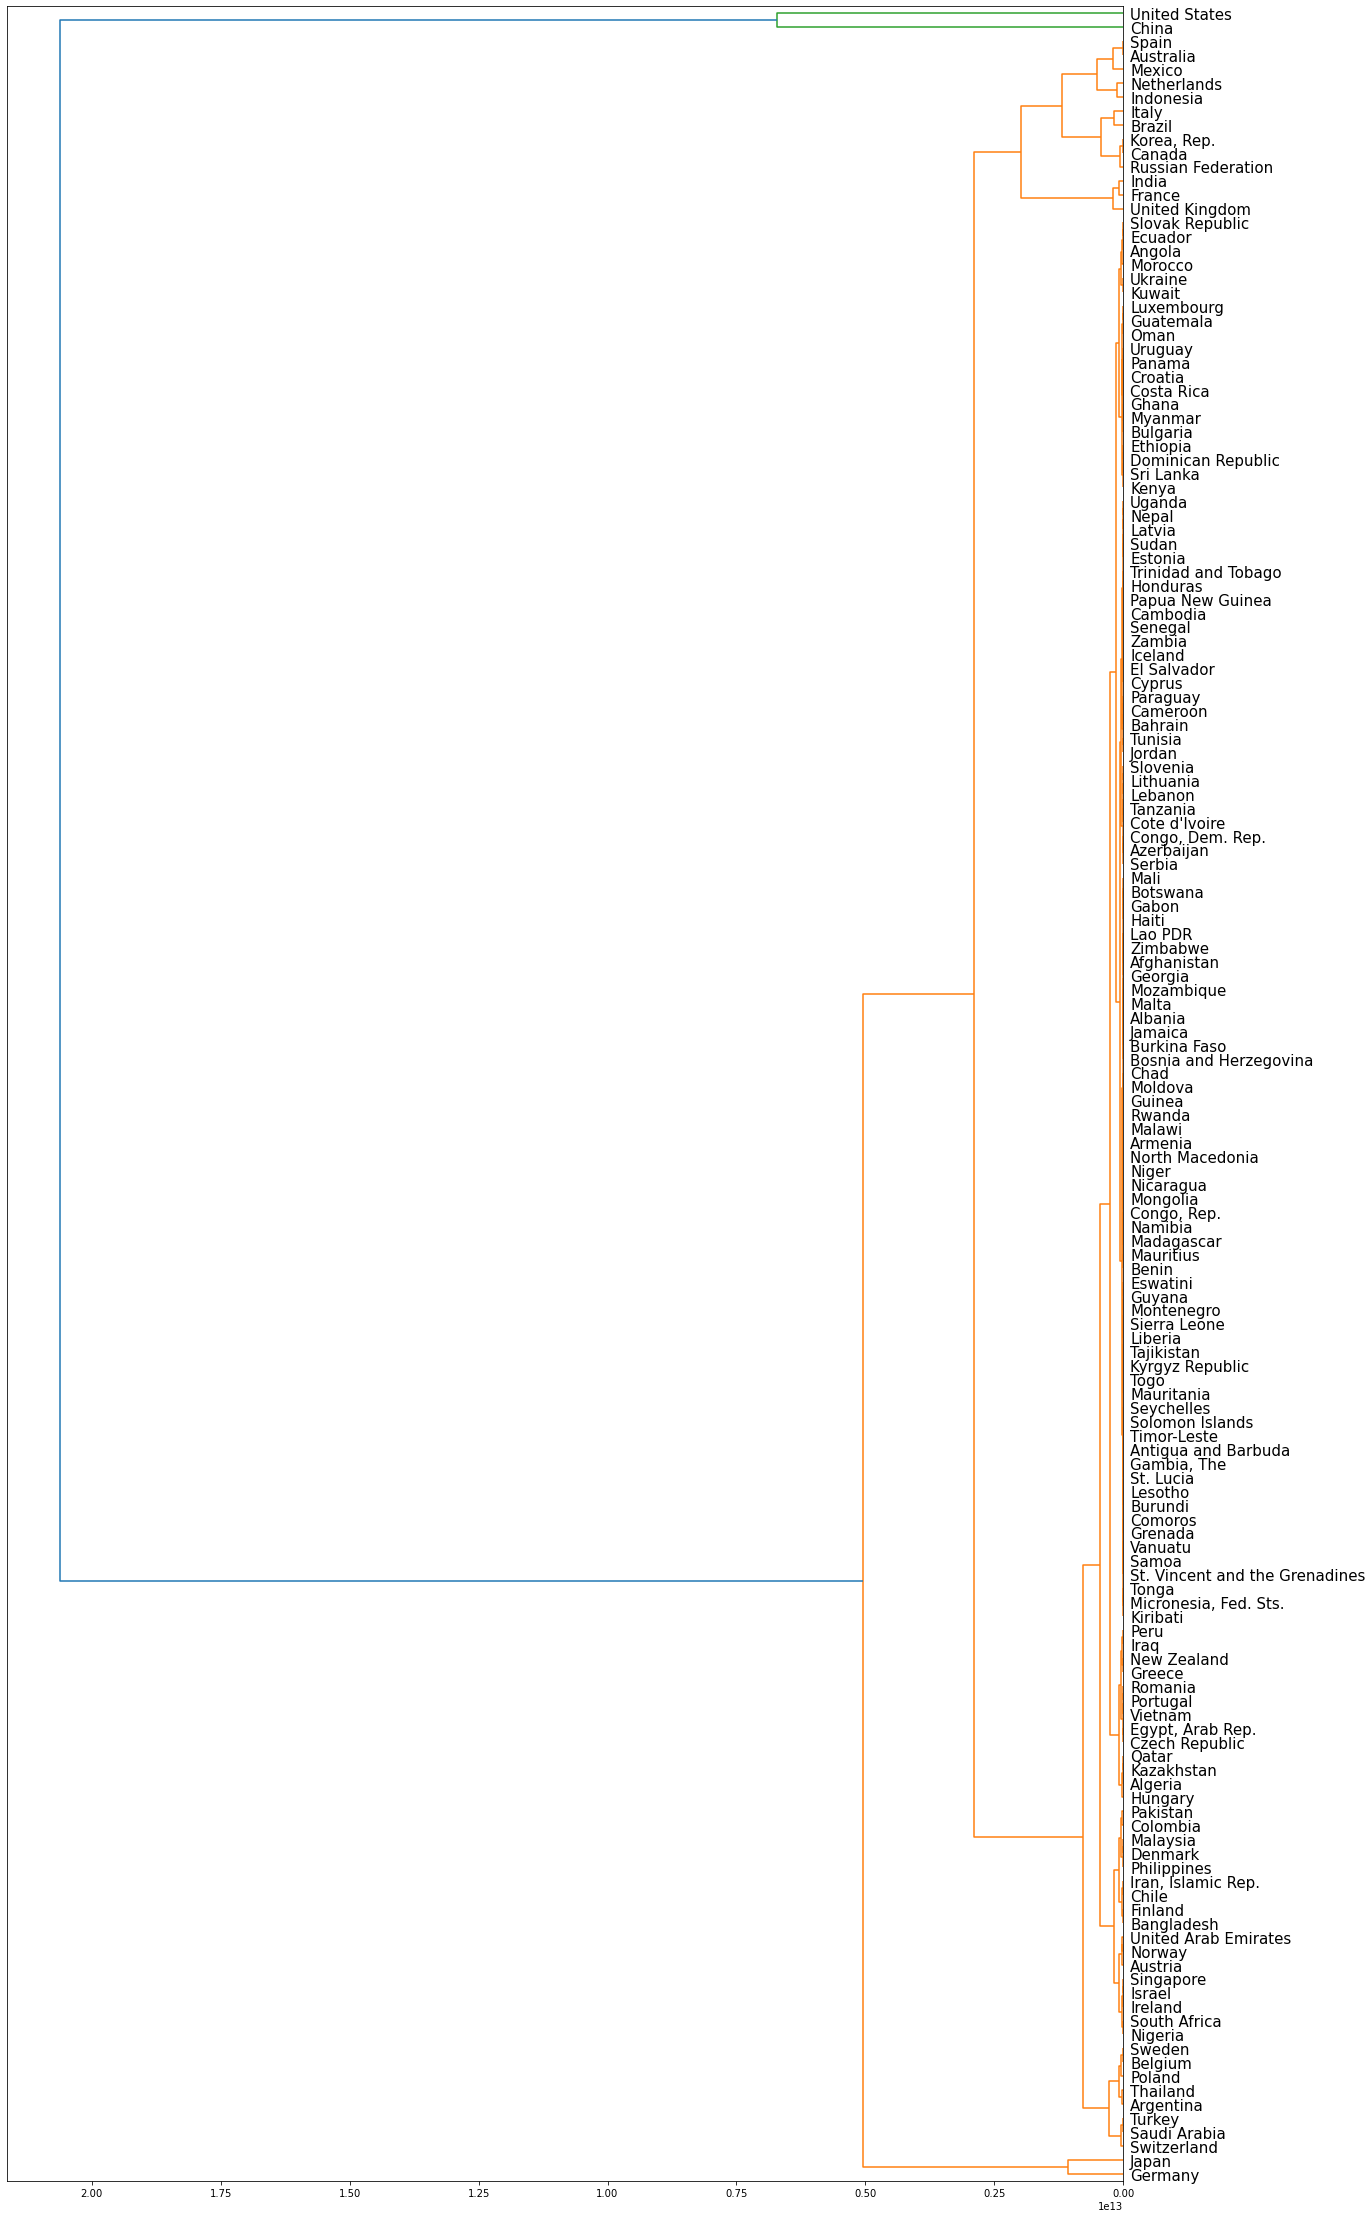

In [17]:
Z = sch.linkage(X, method='complete', metric='euclidean',optimal_ordering=True)
#Draw the dendrogram:
fig = plt.figure(figsize=(20, 40))
dendro = sch.dendrogram(Z, orientation='left', leaf_rotation=0, leaf_font_size=15,labels=list(full_clean_dataset['country_name']))

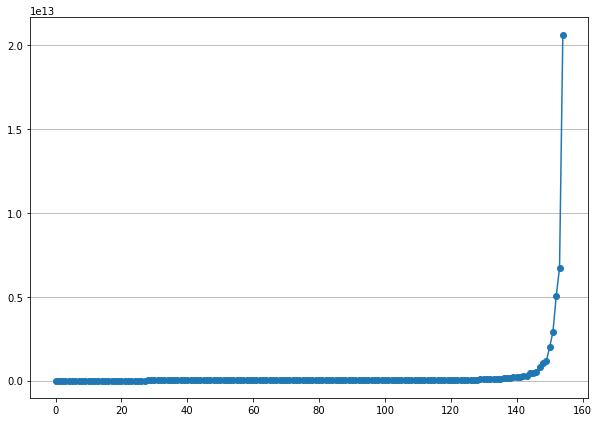

In [18]:
fig = plt.figure(figsize=(10, 7))
plt.plot(Z[:,2],'o-')
plt.grid(axis='y')

We used complete hierachical clustering. By looking at the curving distance curve, it seems that 6 groups can be highlighted. We will test this method with 6 clusters.

#### DBScan

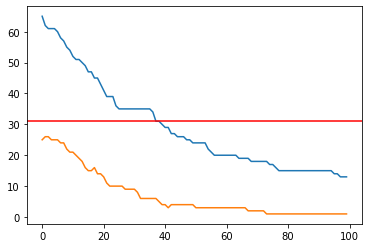

In [19]:
objects=full_clean_dataset[['health_cost_percent','health_cost_capita_percent','health_oop_cost','gdp','gdp_capita','hci']]
#We must scale and center data in order to use dbscan efficiently
objects = (objects - objects.mean()) / (objects.max() - objects.min())
unclassified = []
nb_cluster = []
for i in range(0,100):
    dbscan = DBSCAN(eps=(0.10 + (i*0.001)), min_samples=2)
    dbscan.fit(objects)
    unclassified.append(np.count_nonzero(dbscan.labels_ == -1))
    nb_cluster.append(max(dbscan.labels_))
plt.plot(list(range(0,100)),unclassified)
plt.plot(list(range(0,100)),nb_cluster)
plt.axhline(y = len(objects)*0.2, color = 'r', linestyle = '-',label="20% of value is unclassified")

If we want at least 80% of our values to be classified, we must choose eps ~>0.136. We choose eps = 0.145

In [20]:
dbscan = DBSCAN(eps=0.145, min_samples=2)
dbscan.fit(objects)
dbscan.labels_

array([-1,  0,  0,  0,  0,  0, -1,  1,  1, -1,  0,  0,  1,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0, -1,  2,  2,  0, -1,
        0, -1,  0,  3, -1,  4,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  4,  0, -1,  0, -1, -1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  1,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1, -1, -1,  0,
        0,  0,  0], dtype=int64)

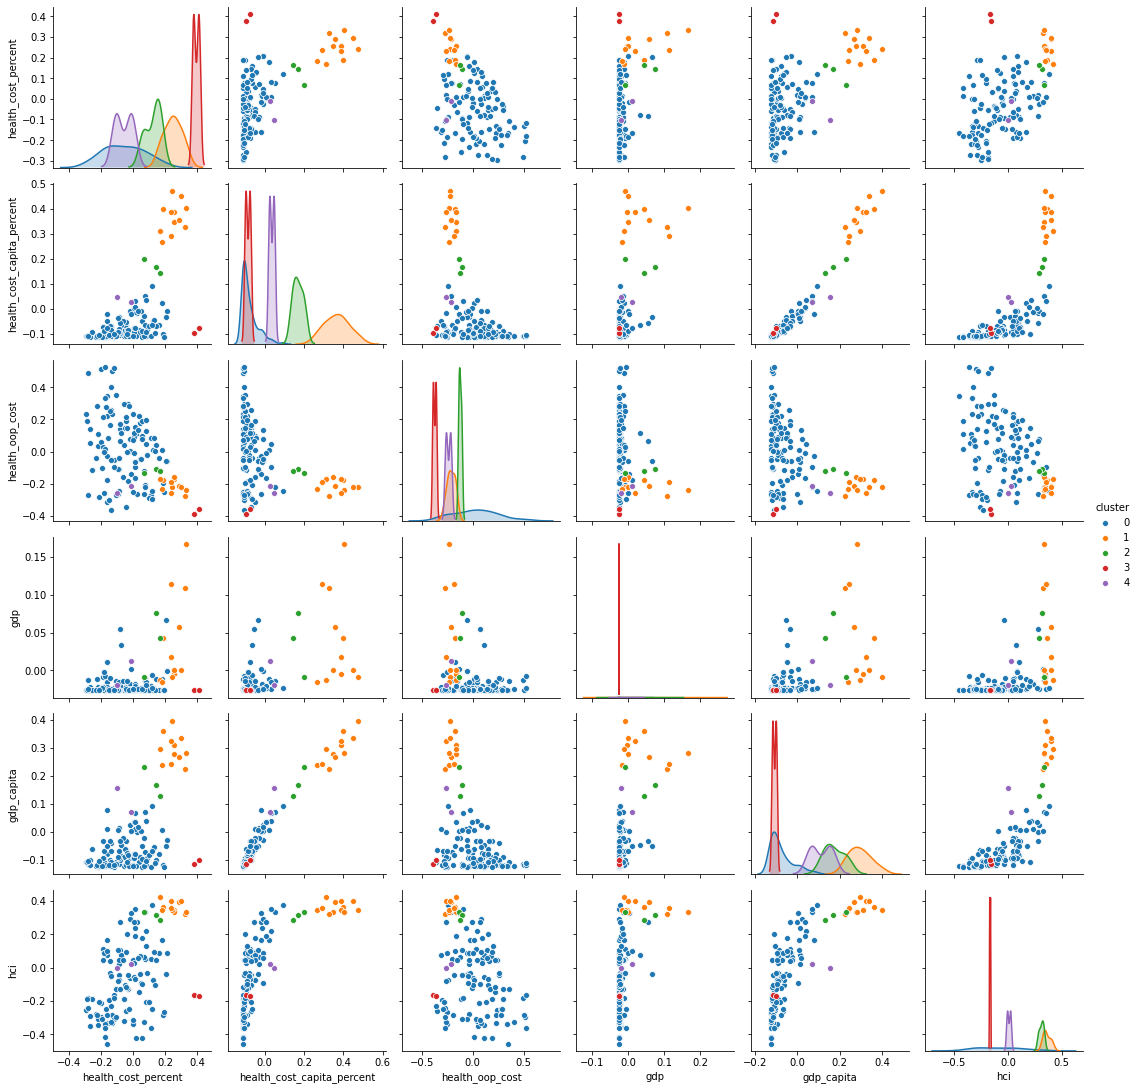

In [21]:
cluster = dbscan.labels_
objects['cluster']= cluster
no_noise_objects = objects[objects['cluster']!=-1]
sns.pairplot(data=no_noise_objects,hue='cluster')

DBScan seems to have difficulties in differentiating clusters. There seems to be a lot of noise in his prediction. This may be caused by scaling and centering of the data.

#### K-means

[]

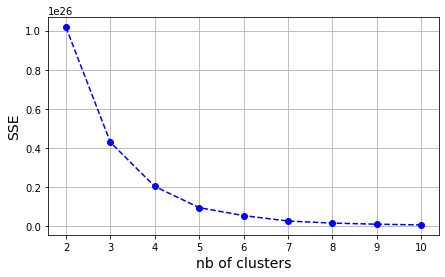

In [22]:
# Get SSE when varying the number of clusters
objects=full_clean_dataset[['health_cost_percent','health_cost_capita_percent','health_oop_cost','gdp','gdp_capita','hci']]
sse_list = []
for i in range(2,11):
    km_i_clusters=KMeans(n_clusters=i)
    km_i_clusters.fit(objects)
    sse_list = sse_list + [km_i_clusters.inertia_]
fig = plt.figure(figsize=(7, 4))
plt.plot(list(range(2,11)),sse_list,'bo--')
plt.grid()
plt.xlabel("nb of clusters",fontsize=14)
plt.ylabel("SSE",fontsize=14)
plt.plot()

By comparing SSE values, 4 or 5 clusters seem to be good choices. We decide to choose 5 clusters.

In order to know if our data are noisy or if the clusters are easily drawn, we study the stability of the K-means convergence

In [23]:
def compute_stability(km,df,iterations=100):
    avg_silhouette_coef = []
    sse_list = []
    for i in range(100):
        km.fit(df)
        labels = km.predict(df)
        avg_silhouette_coef.append(silhouette_score(df, labels,metric='euclidean'))
    avg_silhouette_coef = np.asarray(avg_silhouette_coef)
    return(avg_silhouette_coef.std())

In [24]:
km = KMeans(n_clusters=5,init='random',n_init=1,random_state=1) # create a KMeans object
compute_stability(km,objects)

1.1102230246251565e-16

Variance is very low, whatever the initial point chosen by Kmeans, the convergence clusters seem to be the same

In [25]:
km=KMeans(n_clusters=5)
result=km.fit(objects)

#### Method Comparision

1) Hierachical Clustering Score - 6 clusters

0.33974358974358976


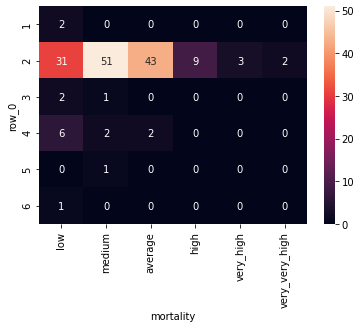

In [26]:
clusters = sch.fcluster(Z, 6, criterion='maxclust')
classes=pd.cut(full_clean_dataset["mortality"],6, labels=["low","medium", "average", "high","very_high","very_very_high"])
crosstab=pd.crosstab(clusters,classes)
sns.heatmap(crosstab, annot=True)
accuracy = np.diag(crosstab).sum() / crosstab.to_numpy().sum()
print(accuracy)

2) DBScan - 5 clusters

0.5846153846153846


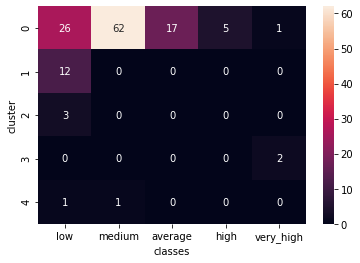

In [27]:
cluster = dbscan.labels_
objects['cluster']= cluster
objects['classes']= pd.cut(full_clean_dataset["mortality"],5, labels=["low","medium", "average", "high","very_high"])

no_noise_objects = objects[objects['cluster']!=-1]

crosstab=pd.crosstab(no_noise_objects['cluster'],no_noise_objects['classes'])
sns.heatmap(crosstab, annot=True)
accuracy = (62 + 12 + 2) / crosstab.to_numpy().sum()
print(accuracy)

3) Kmeans - 5 clusters

0.4935897435897436


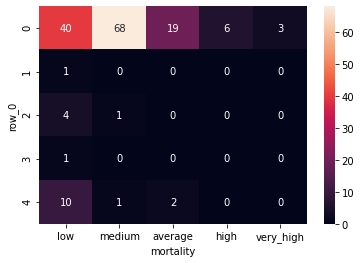

In [28]:
clusters=result.labels_
classes=pd.cut(full_clean_dataset["mortality"],5, labels=["low","medium", "average", "high","very_high"])
crosstab=pd.crosstab(clusters,classes)
sns.heatmap(crosstab, annot=True)
accuracy = (69 + 8) / crosstab.to_numpy().sum()
print(accuracy)

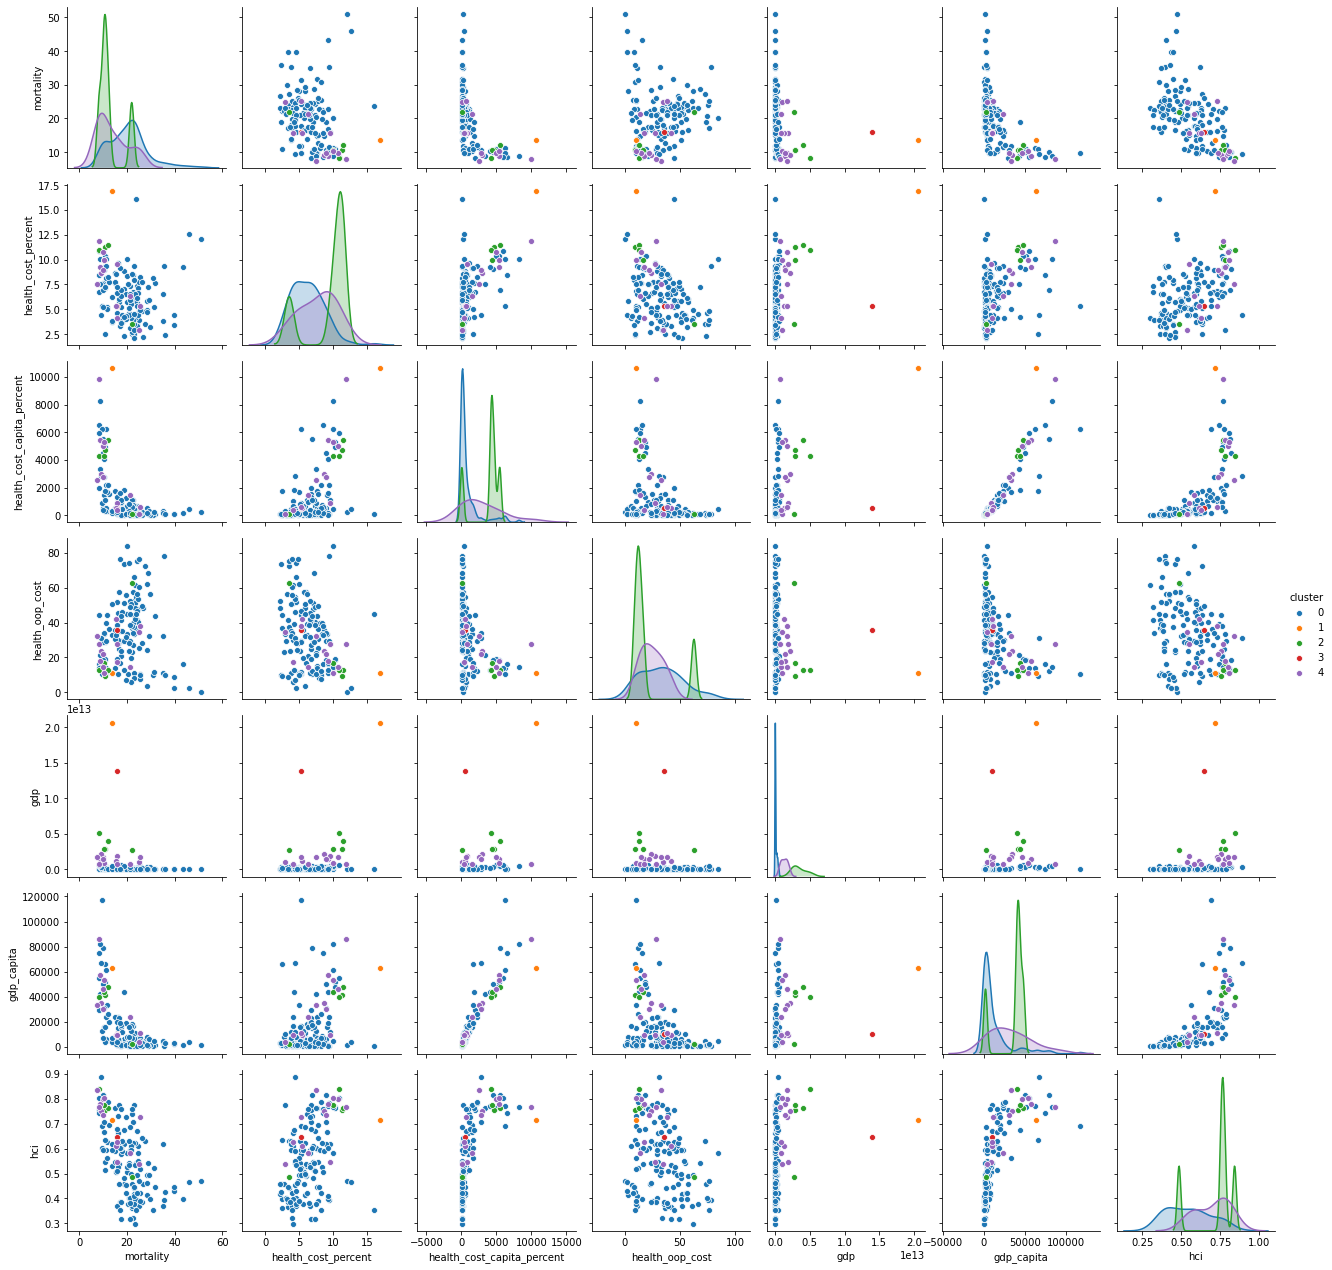

In [29]:
objects = full_clean_dataset.copy()
objects['cluster']= clusters
sns.pairplot(data=objects,hue='cluster')

In [30]:
objects[objects['cluster']==3]

,country_name,country_code,mortality,health_cost_percent,health_cost_capita_percent,health_oop_cost,gdp,gdp_capita,hci,mortality_class,cluster
41,China,CHN,16.0,5.35108,501.059387,35.750656,1.389482e+13,9905.342004,0.647099,low,3


We can't find any real relation between the different countries by using Clustering on our dataset.

We can only spot 3 tendencies

* A first group of countries that look globally similar. It contains Australia, France, Italy, Korea, Canada for instance. (cluster 2)

* A second group of countries which contains only Germany and Japan that seem to be really cost-efficient in decreasing mortality

* Two specific countries considered as alone in their cluster because of their specificity : China and USA 
    * China has a very high GPD but an average health system
    * USA has a very expensive health system but not cost efficient at all

Classification
==============

The goal of this section is to train Machine Learning classifiers to predict the cancer mortality of a given country from its other attributes

* Construct a label by discretisation of an attribute (this label can be built by clustering the values of this attribute). Use this label as class label.

* Compare the results obtained using decision trees and the K nearest neighbors.

* Evaluate the quality of the model using cross validation. Report the score for each subset and the global score.

* Modify the learning parameters to detect of possible overfitting.


Remarks:

- A contingency table can be use to analyse the errors by class.

- Removing outliers can reduce error.

- A classification model can be use to predict labels of a targeted attribute for objects where this attribute value is missing.


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

+ We have already clustered the values of "mortality" in the Clustering section. We can use this label.
+ Now, we split the dataset into a train and test set

In [32]:
#classes=pd.cut(full_clean_dataset["mortality"],5, labels=["low","medium", "average", "high","very_high"])
X=full_clean_dataset.copy()
y=pd.cut(full_clean_dataset["mortality"],5, labels=["low","medium", "average", "high","very_high"])
print(collections.Counter(y))
del X['country_name']
del X['country_code']
del X['mortality_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0) #try with test_size=0.20

Counter({'medium': 70, 'low': 56, 'average': 21, 'high': 6, 'very_high': 3})


Here we see that the distribution of the data has some lack for high and very_high classified data.
He can cause some problem of prediction accuracy for high classes

+ Then, we create a Decision Tree instance

In [33]:
dt = DecisionTreeClassifier()

+ We fit the Decision Tree using the training set

In [34]:
dt.fit(X_train,y_train)

DecisionTreeClassifier()

+ We use the DecisionTree to predict the class membership of the test set instances

In [35]:
y_predict = dt.predict(X_test)

+ We can now compute the confusion matrix and model's accuracy by comparing y_test and the prediction we have just made y_predict

0.9615384615384616


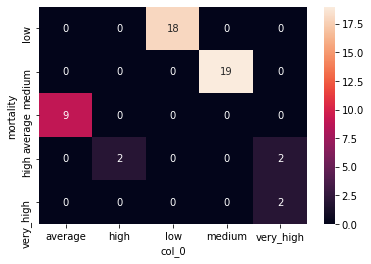

In [36]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_predict))
sns.heatmap(pd.crosstab(y_test,y_predict), annot=True)

Our model seems to have a very good accuracy in predicting the mortality class.

#### K nearest neighbors

In [37]:
#Attributes may have to be scaled to prevent distance measures from being dominated by one of the attributes
#But I think it's ok since we've already done that for clustering section

In [38]:
from sklearn.preprocessing import StandardScaler
zscore = StandardScaler().fit(X)
X_z = pd.DataFrame(zscore.transform(X), index=X.index, columns=X.columns)

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
knn = KNeighborsClassifier()
scores = cross_validate(knn, X, y, return_train_score=True)
scores = pd.DataFrame(scores).mean()

knn = KNeighborsClassifier()
scores_z = cross_validate(knn, X_z, y, return_train_score=True)
scores_z = pd.DataFrame(scores_z).mean()

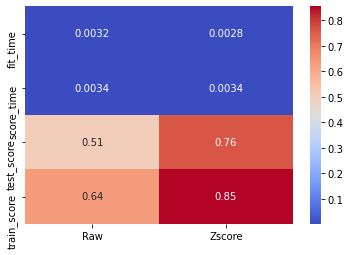

In [40]:
full_scores = pd.DataFrame({"Raw": scores, "Zscore":scores_z})
sns.heatmap(full_scores,annot=True,cmap='coolwarm')

In [41]:
n_neighbors = [1,3,5]
weights = ["uniform", "distance"]
distances = ["euclidean","manhattan"]

scoring = ['accuracy','precision_weighted','recall_weighted','f1_weighted']

full_scores = {}
for k in n_neighbors:
    for d in distances:
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=d)
            scores = cross_validate(knn, X_z, y, scoring=scoring, return_train_score=True)
            scores = pd.DataFrame(scores).mean()
            full_scores[str(k)+"-"+d+"-"+w] = scores

*Warning caused by the lack of data in some classes*

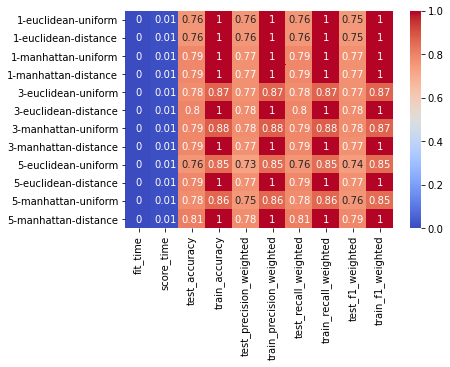

In [42]:
full_scores = pd.DataFrame(full_scores)
sns.heatmap(full_scores.T.round(2),annot=True,cmap='coolwarm')

It seems that the predictions obtained with the Decision Tree method are more accurate than the ones obtained by using K nearest neighbors method. In fact, the accuracy of our results obtained by Decision Tree method are 96% accurate, whereas the ones obtained by K nearest neighbors are around 80%.

#### Cross validation

+ We want to evaluate the quality of our model using cross validation

In [43]:
from sklearn.model_selection import StratifiedKFold #cross-validation splitter
from sklearn.model_selection import cross_validate #cross-validation evaluation of metrics

To do so, we create a stratified cross-validation splitter

In [44]:
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [45]:
scoring_ = ['accuracy','precision_macro','precision_weighted','recall_macro','recall_weighted','f1_macro','f1_weighted']
scores = cross_validate(dt, X, y, scoring=scoring_,cv=cv, return_train_score=True)

In [46]:
pd.DataFrame(scores).mean()

fit_time                    0.003008
score_time                  0.008190
test_accuracy               0.987298
train_accuracy              1.000000
test_precision_macro        0.943333
train_precision_macro       1.000000
test_precision_weighted     0.983669
train_precision_weighted    1.000000
test_recall_macro           0.957143
train_recall_macro          1.000000
test_recall_weighted        0.987298
train_recall_weighted       1.000000
test_f1_macro               0.948779
train_f1_macro              1.000000
test_f1_weighted            0.984819
train_f1_weighted           1.000000
dtype: float64

Global accuracy over all folds: 0.987298 (+/- 0.031119)
For each metric, list the score values on each fold:


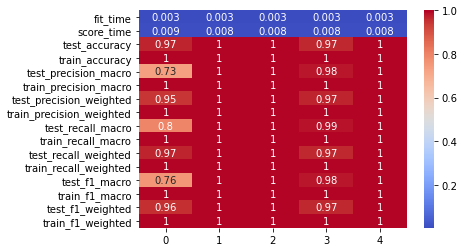

In [47]:
print('Global accuracy over all folds: %0.6f (+/- %0.6f)'
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
print('For each metric, list the score values on each fold:')
full_scores = pd.DataFrame(scores)
sns.heatmap(full_scores.T.round(3),annot=True,cmap='coolwarm')

The global score and the score of each subset allow us to validate our model quality.

Global accuracy over all folds: 0.987097 (+/- 0.031606)


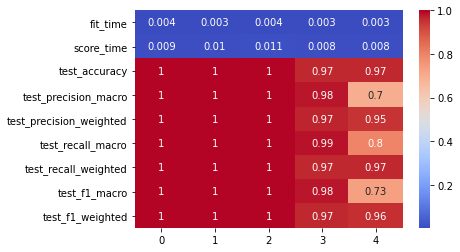

In [48]:
#another method
from sklearn import tree
model = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=10, min_samples_leaf=3)
scores = cross_validate(model, X, classes, scoring=scoring_,cv=cv, return_train_score=False)
print('Global accuracy over all folds: %0.6f (+/- %0.6f)'
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
full_scores = pd.DataFrame(scores)
sns.heatmap(full_scores.T.round(3),annot=True,cmap='coolwarm')

#### Detect overfitting

In [49]:
import matplotlib.pyplot as plt

In [50]:
# Test several maximum numbers of leaves
cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
results = {}
for leaves in range(2,20):
    dt = DecisionTreeClassifier(max_leaf_nodes=leaves,criterion="entropy")
    
    local_results = cross_validate(dt, X, y, scoring=["accuracy"],cv=cv, return_train_score=True)
    avg_local_results = pd.DataFrame(local_results).mean()
    results[leaves] = avg_local_results
results_df = pd.DataFrame(results)

No handles with labels found to put in legend.


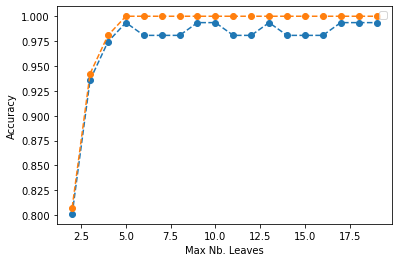

In [51]:
plt.plot(results_df.T.index , results_df.T["test_accuracy"],"o--")
plt.plot(results_df.T.index , results_df.T["train_accuracy"],"o--")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Nb. Leaves")
plt.show()

We see that the accuracy doesn't increase if we add more leaves. It seems to be no overfitting.

### Conclusion

#### 1) Materials and method
* __Used clustering technique__

K-means, hierarchical complete/single and DBSCAN.

* __Used classification technique__

Decision Tree and K-nearest Neighbors

* __Used evaluating method for clustering__

SSE score, silhouette coefficient and grouping distance curves

* __Used evaluating method for classification__

Cross validation and overfitting lookup

#### 2) Results



#### 3) Discussion

Report content and format
=========================

* Keep track of the choices made and justify them.

* Give commands and parameters so that the results can be reproduced.

* Show in tables some views of subsets of the data, but not the complete view of all objects in the data. Give the attributes and their units, as well as the number of objects used.

* Give results (values, graphics,...).

* Try to interpret the results in the domain.


Remarks:

- It is possible to study several subsets of attributes (e.g., one for the clustering part, another for the classification tasks).

- The report can suggest directions for future works, e.g., directions that have not been explored due to time constraints.

- The document can be split in two reports: one for the clustering and one for the classification tasks.


How to edit the report
======================

A way to prepare the report is to add "Markdows" cells in the Jupyter notebook to insert text, and use #, ##, ###, #### for headings (section, subsection, subsubsection, paragraph). Next, to get a latex version of the notebook use: "File -> Download as -> LaTeX" (this requires Pandoc to be installed https://pandoc.org/installing.html). And then edit the .tex if needed (to add a title page, to clean some parts, ...), before compiling it.

IMPORTANT 1: the end of long lines in cells containing python commands can be suppressed (due to the latex verbatim mode), to avoid this use lines of at most 80 characters and use "\" to continue the command on the next line.

IMPORTANT 2: if using "File -> print preview" to generate a pdf of the notebook, then the sections will not be numbered, and check also that there is no missing part in long lines.

IMPORTANT 3: "File -> Download as -> LaTeX" may not work for the graphical representation of decision trees, depending on the version of sklearn and on external installed softwares. A workaround is to generate the pdf of the tree and then to include the pdf by a latex command.
Example, with a cell containing the code:
graph = graphviz.Source(dot_data)
graph # to display the tree

replace the cell content by:
graph = graphviz.Source(dot_data)
graph.render("out_iris_decision_tree") # to generate a pdf file

then just below this cell add a Markdown cell containing the following tree lines:
\begin{center}
\adjustimage{max size={0.9\linewidth}{0.9\paperheight}}{out_iris_decision_tree.pdf}
\end{center}

then generate the latex file with "File -> Download as -> LaTeX", put the file out_iris_decision_tree.pdf in the folder of the latex file, and compile the latex file.

---

Zip file to be send by mail
===========================
(mail to Christophe.Rigotti@insa-lyon.fr and Sergio.Peignier@insa-lyon.fr)

Prepare a single folder with name the names of the authors (in lexicographic order): NAME1_NAME2. Zip this folder and send the file NAME1_NAME2.zip

The folder must contains:

- zip file(s) of the data file(s), (txt format to reproduce the work). 

- file(s), (txt format or pdf) containing the definitions of the variables given by the data provider.

- the Jupyter notebook(s) (format .ipynb to reproduce the work).

- the report in one or two pdf files.

